In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, vstack
from astropy.wcs import WCS

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, Rectangle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

### Catalogues of clusters and photon lists:

In [4]:
clusters_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters_all[clusters_all["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]

wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

clusters

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


Stacked image of all slices in the lightcone:

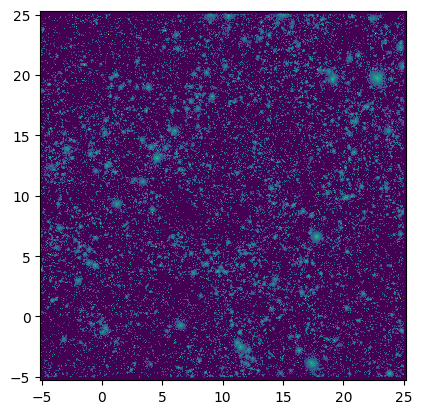

In [5]:
t_all = pd.DataFrame([])
for p in phlists:
    t = Table.read("../data/eROSITA_30.0x30.0/Phox/"+p, hdu=2)
    t_all = vstack([t_all, t])
    
plt.hist2d(t_all["RA"], t_all["DEC"], bins=2000, norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1))
plt.gca().set_aspect('equal', 'box')
plt.show()

### Binning clusters:

In [6]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)

binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


### Catalogue of galaxies:

In [188]:
galaxies_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/galaxies.dat", sep='\s+', header=0)
galaxies_all

,isub,x_pix,y_pix,z_pix,vmax,z_true,z_obs,Mstar,sfr,u,...,z,Y,J,H,K,L,M,Age,Z,flag
0,201683,0.962549,0.467828,-0.002068,482.064,0.156636,0.156890,43.348600,3.053100,-22.5014,...,-24.7014,-24.9937,-25.3885,-26.0246,-26.2821,-26.4280,-26.4574,0.269562,1.053180,1
1,294417,0.308135,0.547052,-0.001271,394.019,0.156666,0.158137,30.742500,0.000000,-21.9320,...,-24.3703,-24.6621,-25.0561,-25.6940,-25.9519,-26.0967,-26.1231,0.312990,1.006500,1
2,428854,0.239429,0.219663,-0.000989,316.786,0.156676,0.156816,16.174300,0.000000,-21.2007,...,-23.6519,-23.9443,-24.3406,-24.9775,-25.2325,-25.3763,-25.4013,0.316229,1.001770,1
3,260150,0.176925,0.999731,-0.000952,413.087,0.156678,0.155405,43.030700,0.000000,-22.2601,...,-24.7233,-25.0224,-25.4214,-26.0616,-26.3205,-26.4663,-26.4947,0.316437,1.050650,1
4,441383,0.756445,0.922726,-0.000933,259.644,0.156678,0.156527,9.024170,0.000000,-20.4671,...,-22.9383,-23.2374,-23.6374,-24.2763,-24.5329,-24.6785,-24.7070,0.267401,1.092940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632086,1638584,0.090051,0.010463,0.999554,119.088,0.050463,0.050948,0.256724,0.279066,-19.6446,...,-20.0053,-20.1091,-20.3440,-20.8969,-21.1480,-21.2692,-21.2597,0.617970,0.200753,0
632087,1417538,0.133690,0.629479,0.999680,124.889,0.050467,0.051280,0.365516,0.872128,-20.8601,...,-21.0364,-21.2277,-21.5090,-22.1232,-22.4427,-22.6011,-22.6442,0.760209,0.531133,0
632088,197071,0.984320,0.001112,0.999711,113.671,0.050468,0.046894,0.280967,1.032990,-19.3255,...,-20.9473,-21.1335,-21.3442,-22.0208,-22.4384,-22.6206,-22.6835,0.799404,0.305648,0
632089,1182914,0.523695,0.528769,1.000098,130.264,0.050481,0.051212,1.220900,0.532199,-20.7506,...,-21.8453,-22.1433,-22.5103,-23.1606,-23.4823,-23.6515,-23.7068,0.665157,0.810235,1


### Single cluster: pure ICM photons (no AGNs)

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
2270,5,0.132094,0.683505,0.238968,0.007008,8.050390e+14,0.165672,0.165388,4.841240e+14,1048.91,1.277250e+13,5.734860e+13,6.00627,25.0979,0.000014,6.741010e+14,1589.63,0


<Figure size 640x480 with 0 Axes>

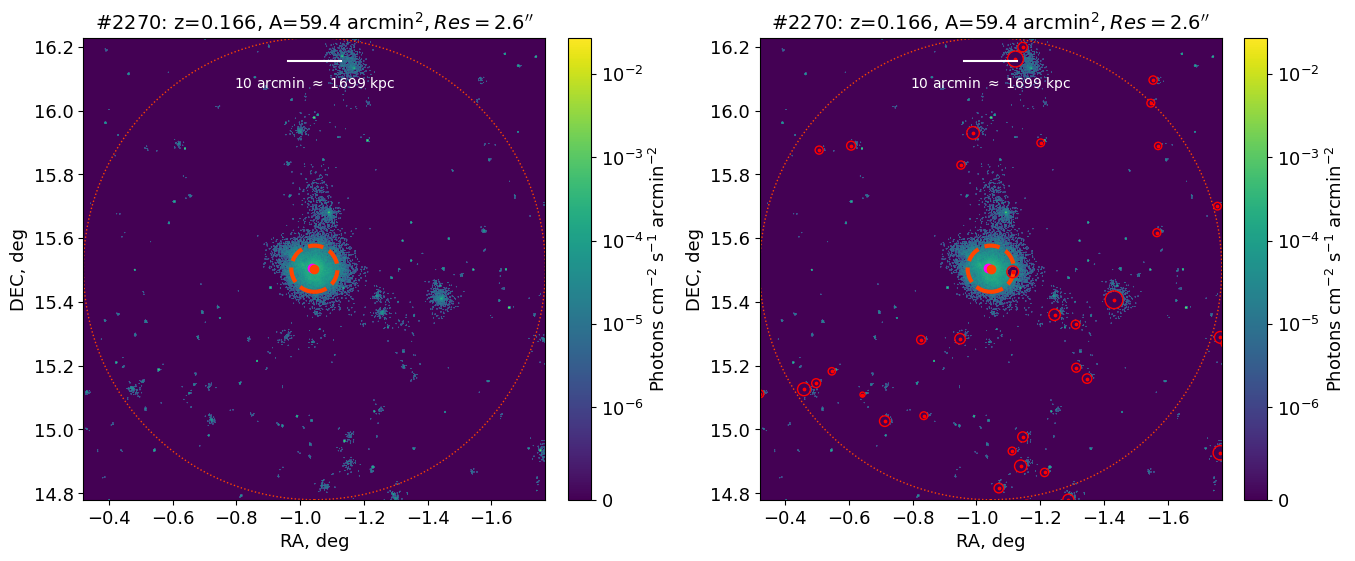

In [347]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(16,6))
plt.tight_layout()

cl_num = 2270

display(clusters[clusters.index==cl_num])

plt.subplot(121)
pho_hist1 = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False, 
                                        ARF_weights=False)

plt.subplot(122)
pho_hist2, msk = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=True, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False, 
                                        ARF_weights=False)

#print(sum(pho_hist1.flatten()), sum(pho_hist2.flatten()))
#display(plist1, plist2)

plt.show()

### Drawing panels:

In [ ]:
%run -i 'utils/scripts.py'

draw_84_panels()

plt.savefig('panels_filtered.png', format='png', dpi=100, bbox_inches='tight')
plt.close()
plt.show()

#### This is 2d histogram of all the photons in $20 R_{500} \times 20 R_{500}$ field. To each bin of histogram correspond the number of photons in it, which then is divided by 1000 cm$^2$, 10000 s and area of bin (which varies from cluster to cluster because every image has 2000 pixels in length) to obtain the flux in corresponding units.

### Filtering of images:

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


<Figure size 640x480 with 0 Axes>

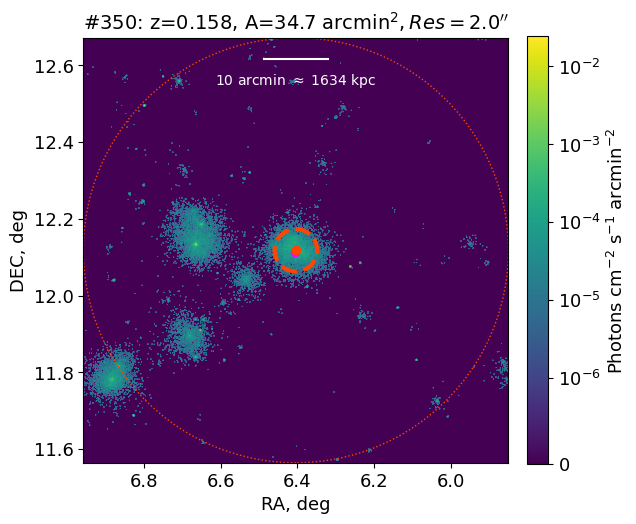

In [366]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

cl_num = 350

display(clusters[clusters.index==cl_num])

tyty0 = extract_photons_from_cluster(cl_num, 
                                    r = 1.0, 
                                    centroid=True, 
                                    delete_superfluous=False, 
                                    draw=True,
                                    histlen=2001,
                                    withagn=False, 
                                    ARF_weights=False)

plt.show()

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


<Figure size 640x480 with 0 Axes>

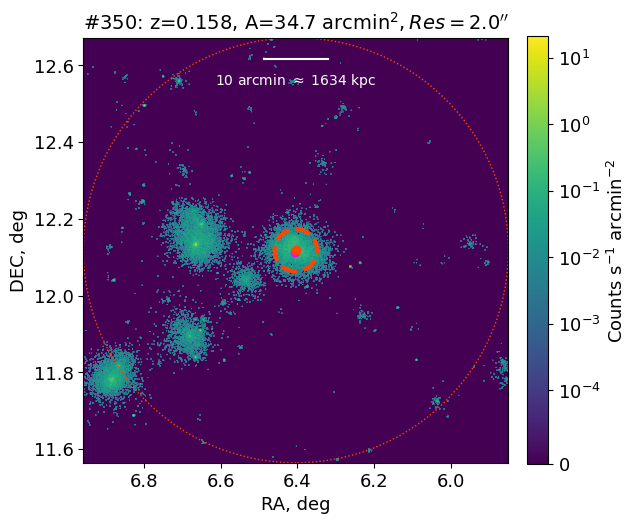

In [367]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

cl_num = 350

display(clusters[clusters.index==cl_num])

tyty1 = extract_photons_from_cluster(cl_num, 
                                    r = 1.0, 
                                    centroid=True, 
                                    delete_superfluous=False, 
                                    draw=True,
                                    histlen=2001,
                                    withagn=False, 
                                    ARF_weights=True)
plt.show()

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


<Figure size 640x480 with 0 Axes>

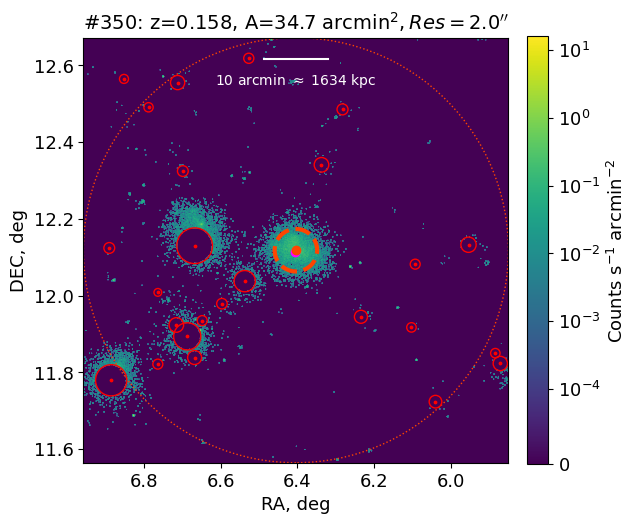

In [368]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

cl_num = 350

display(clusters[clusters.index==cl_num])

tyty2, msk = extract_photons_from_cluster(cl_num, 
                            r = 1.0, 
                            centroid=True, 
                            delete_superfluous=True, 
                            draw=True,
                            histlen=2001,
                            withagn=False, 
                            ARF_weights=True)
plt.show()

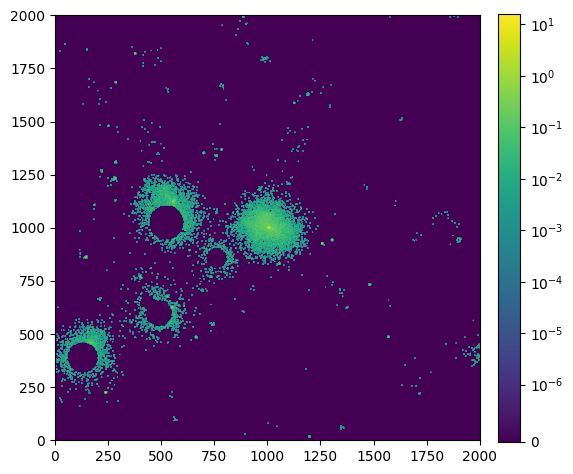

In [369]:
plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(tyty2*(1-msk))), origin='lower', norm=matplotlib.colors.SymLogNorm(linthresh=0.000001, linscale=1))
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

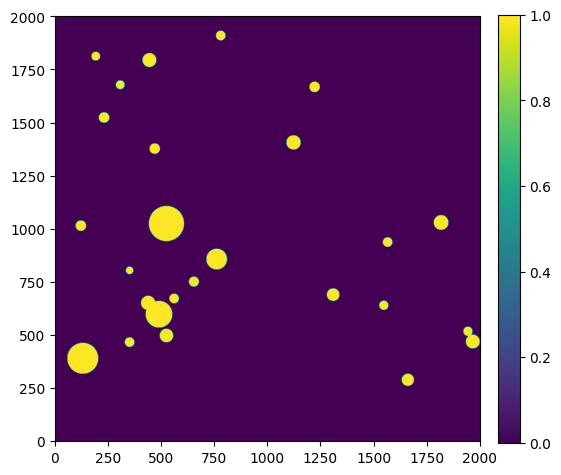

In [370]:
plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(msk)), origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

### Calculating brightness profile for one cluster (which is above):

Original:

  0%|          | 0/24 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

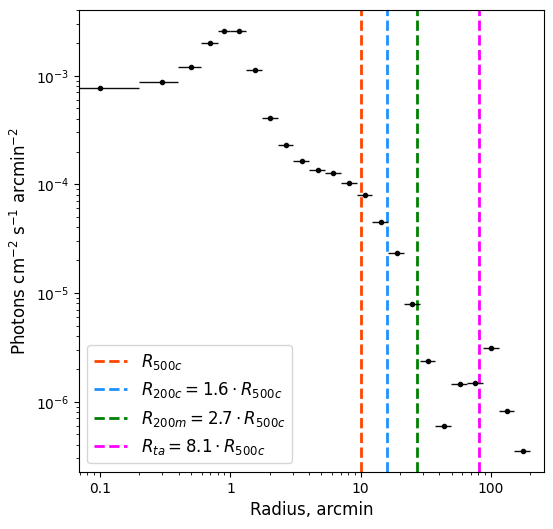

In [376]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=tyty0,
                          mmmask='no',
                          field_length=20,
                          draw=True,
                          ARF_weights=False)

plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

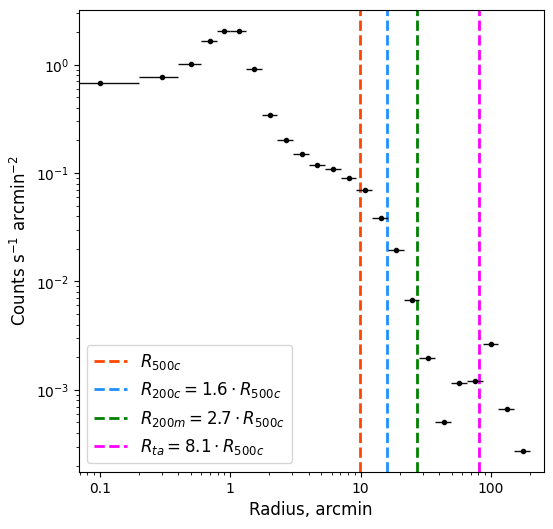

In [377]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=tyty1,
                          mmmask='no',
                          field_length=20,
                          draw=True,
                          ARF_weights=True)

plt.show()

Filtered:

  0%|          | 0/24 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

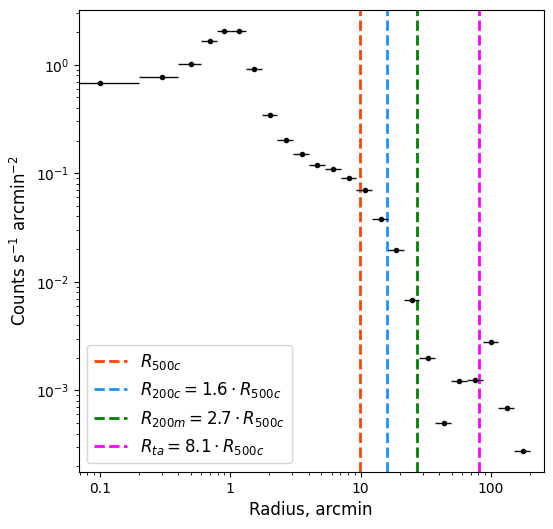

In [378]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=tyty2,
                          mmmask=msk,
                          field_length=20,
                          draw=True,
                          ARF_weights=True)

plt.show()

### Calculating profiles for each cluster:

In [ ]:
%run -i 'utils/scripts.py'

df_all = pd.DataFrame()

for cl_num in tqdm(clusters.index[:84]):

    pho_hist = extract_photons_from_cluster(cl_num, 
                                            r = 1,
                                            delete_superfluous=False,
                                            draw=False,
                                            histlen=2001,
                                            ARF_weights=True)

    brbr = brightness_profile(hist=pho_hist,
                              mmmask='no',
                              field_length=20,
                              draw=False)
    
    df_add = pd.DataFrame(brbr).T      
    df_all = pd.concat([df_all, df_add], axis=0)
    
    df_all.to_csv('brpr.csv', sep=' ', header=False, index=True)

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [33]:
yarkosti = pd.read_csv("brpr.csv", sep='\s+', header=None, index_col=0)
display(yarkosti)
yarkosti = yarkosti.to_numpy()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
0,,,,,,,,,,,,,,,,,,,,,
0,0.342568,0.361820,0.270867,0.190039,0.147162,0.098998,0.052090,0.032420,0.018002,0.012939,...,0.001872,0.001036,0.000451,0.000159,0.000038,0.000007,0.000004,0.000014,0.000030,0.000033
0,0.033861,0.054420,0.043536,0.052404,0.051061,0.105638,0.139770,0.034802,0.014186,0.009136,...,0.002091,0.001363,0.001006,0.000339,0.000111,0.000047,0.000118,0.000518,0.000145,0.000095
0,0.034304,0.039307,0.052885,0.077422,0.119111,0.140831,0.090020,0.027475,0.014614,0.009703,...,0.002644,0.001392,0.000479,0.000139,0.000036,0.000087,0.000090,0.000188,0.000049,0.000021
0,0.018874,0.010486,0.013369,0.014418,0.016602,0.016654,0.020266,0.039409,0.021123,0.012772,...,0.001606,0.000903,0.000615,0.000153,0.000031,0.000019,0.000017,0.000002,0.000006,0.000019
0,0.013192,0.018322,0.032980,0.046722,0.064738,0.107023,0.101900,0.040309,0.010641,0.006620,...,0.001194,0.000676,0.000305,0.000168,0.000048,0.000007,0.000012,0.000031,0.000010,0.000040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.005017,0.003949,0.004738,0.005458,0.006039,0.004755,0.005521,0.007077,0.008112,0.005107,...,0.001715,0.001070,0.000597,0.000420,0.000119,0.000027,0.000040,0.000048,0.000026,0.000012
0,0.001571,0.001963,0.001440,0.001963,0.002399,0.001925,0.001888,0.001992,0.001795,0.002121,...,0.003917,0.000792,0.000421,0.000226,0.000080,0.000023,0.000005,0.000010,0.000007,0.000023
0,0.003946,0.003837,0.002960,0.001644,0.001462,0.002418,0.005059,0.012826,0.029450,0.007333,...,0.000656,0.000482,0.000276,0.000155,0.000078,0.000031,0.000010,0.000016,0.000019,0.000001


<Figure size 640x480 with 0 Axes>

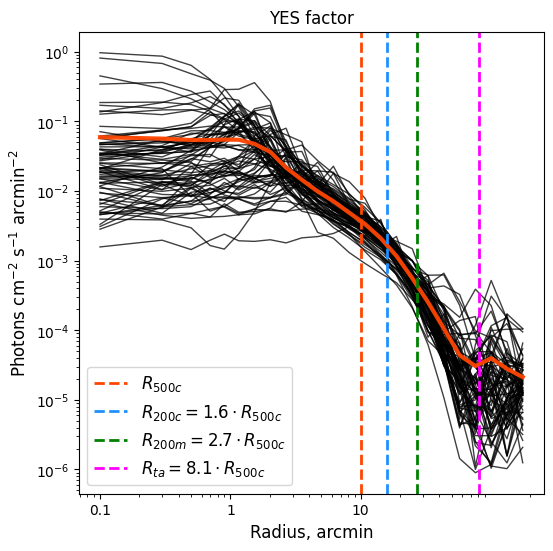

In [35]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

r_pixels_max = 1000 # 5*r500r    # depends on field size
r500r = int(r_pixels_max/20)
setka_bins = np.append([0, 1, 2, 3, 4],np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]  # centers of bins
err = np.diff(setka_bins)/2

yar = np.array(yarkosti[8])*0

#yarkosti = 

for i in range(0, len(yarkosti[::])):

    one = yarkosti[i]
    
    if one[0]==0 or one[1]==0:
        #print(one)
        llww=0
    else:
        llww=1
        
    #print(factor[i])
    
   # one = one * factor[i]
    
    yar = yar + one
    
    plt.plot(np.array(setka)/r500r*(10*998/1000), 
             np.array(one), 
             linewidth=llww, marker='.', markersize=0, alpha=0.75,
             color='black')
    
plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/84, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.95,
         color='orangered')

#plt.errorbar(np.array(setka)/r500r*(10*998/1000), 
#             np.array(yar)/84, 
#             xerr=err/r500r*(10*998/1000), 
#             linewidth=0, marker='.', 
#             markersize=3, alpha=0.95,
#             elinewidth=1, capsize=0, color='orangered')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Photons cm$^{{-2}}$ s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12) # "Brightness in relative units")

plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \cdot R_{500c}$', lw=2)

plt.title("YES factor")
#plt.ylim(1e-8, 4e-2)
    
plt.legend(loc=3, fontsize=12)
plt.xticks([0.1, 1, 10], [0.1, 1, 10])
plt.gca().set_aspect('auto', 'box')

In [51]:
%run -i 'utils/scripts.py'

length = 2000

total_hist = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist = extract_photons_from_cluster(cl_num, r = 1.0, draw=False, delete_superfluous=True, 
                                            withagn=False, ARF_weights=False)[0]
    
    total_hist = np.add(total_hist, pho_hist)

  0%|          | 0/84 [00:00<?, ?it/s]

KeyError: 'RA'

<Figure size 640x480 with 0 Axes>

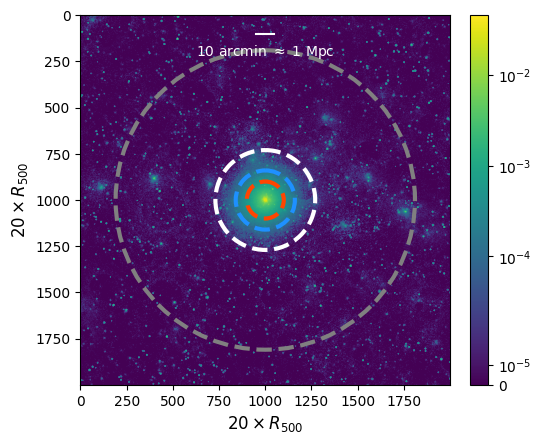

In [50]:
half_length = int(length/2)
r500r = int(half_length/10)

plt.imshow(np.rot90(total_hist), norm=matplotlib.colors.SymLogNorm(linthresh=0.00005, linscale=1), 
           origin='upper')
plt.colorbar(fraction=0.046, pad=0.04)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*8.1, 
                               color='grey', linestyle="--", lw=3, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.xlabel("$20 \\times R_{500}$", fontsize=12)
plt.ylabel("$20 \\times R_{500}$", fontsize=12)

plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

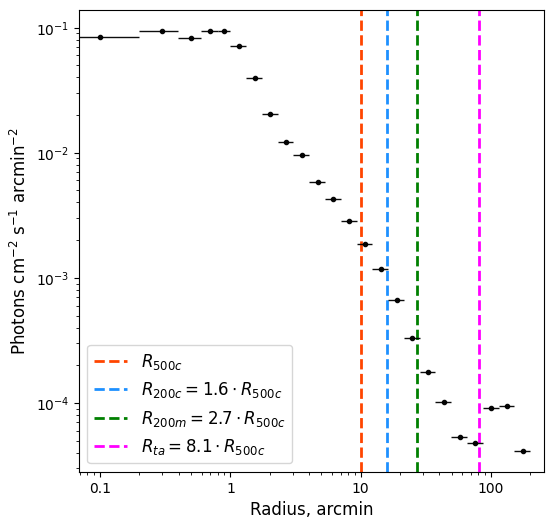

In [48]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(clnumber='all',
                          hist=total_hist,
                          field_length=20,
                          draw=True)

#plt.ylim(3e-9, 6e-2)

plt.show()

### Uploading $eROSITA$'s ARF (for one TM, but $\times 7$):

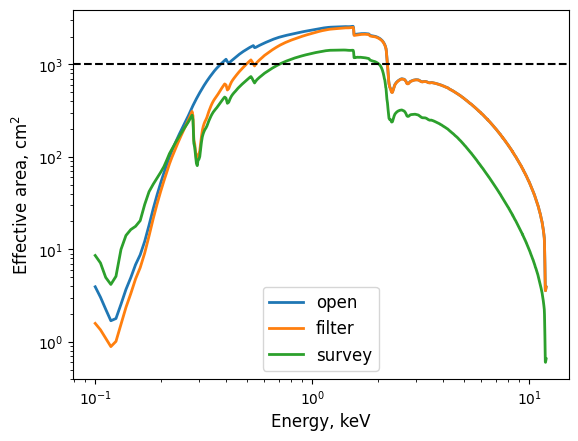

In [190]:
arf_open = fits.open('../erosita/tm1_arf_open_000101v02.fits')[1].data
arf_filter = fits.open('../erosita/tm1_arf_filter_000101v02.fits')[1].data
arf_survey = fits.open('../erosita/esf10.Dsur1234regR3cCaXv2.0001.arf')[1].data

plt.plot(arf_open["ENERG_LO"], 7*arf_open["SPECRESP"], label='open', lw=2)
plt.plot(arf_filter["ENERG_LO"], 7*arf_filter["SPECRESP"], label='filter', lw=2)
plt.plot(arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"], label='survey', lw=2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel('Energy, keV', fontsize=12)
plt.ylabel('Effective area, cm$^2$', fontsize=12)
plt.legend(loc=8, fontsize=12)

plt.axhline(1000, ls='--', color='k')

plt.show()

#### The arf for 'survey' is taken (i.e. FoV averaged). Dashed line indicates flat effective area for pure photons.

In [191]:
sl = plist
#sl["FLUX"] = sl["ENERGY"] / 1000 / 10000 / 4**2 * 60**2      # keV/cm2/s/arc
sl["EFF_AREA"] = np.interp(sl["ENERGY"], arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"]) # cm2
#sl["RATE"] = sl["FLUX"] * sl["EFF_AREA"]    # keV/s

In [193]:
display(sl)

,ENERGY,RA,DEC,EFF_AREA
184785,0.323053,21.348543,20.766006,203.626375
184786,0.343827,21.355482,20.772743,284.265233
184787,0.555965,21.371180,20.770899,682.122756
185727,0.337027,20.876253,20.296146,257.816883
186381,0.543377,22.289717,20.704340,634.104344
...,...,...,...,...
6341113,0.942630,22.602350,18.439213,1276.137104
6341114,1.006420,22.615623,18.453289,1322.000349
6341115,1.149363,22.614796,18.460176,1404.864806
6341116,1.807550,22.611002,18.448803,1162.806014
